In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('new_data.csv')
df = df.set_index('Дата')
df.head(3)

,Доллар США,Евро,Фунт стерлингов,Китайский юань,Японская йена,value_RUB,value_USD,value_EUR,value_GBP,value_JPY,value_CNY
Дата,,,,,,,,,,,
2023-12-05,75.8846,82.8877,95.7512,10.9119,56.5881,7.5,5.06143,-0.64957,4.6877,-0.06005,1.320
2023-11-05,76.6929,84.1498,96.7251,11.0390,56.7465,7.5,5.06171,-0.64957,4.6810,-0.06005,1.102
2023-05-05,78.6139,86.9986,98.5268,11.3488,57.1654,7.5,5.05986,-0.64957,4.6336,-0.06005,1.234


В качестве задачи на машинное обучение мы решили научиться предсказывать курс доллара США, т. к. веса показали, что в него чаще всего выгодно инвестировать. Делать это мы будем на основе курсов евро, фунта стерлингов, китайского юаня и японской йены, т. к. во многом курсы валют взаимосвязаны (как минимум из-за глобальных экономических условий, политических событий и др. факторов). 

In [3]:
df_ml = df.iloc[:, :5]
df_ml.head(3)

,Доллар США,Евро,Фунт стерлингов,Китайский юань,Японская йена
Дата,,,,,
2023-12-05,75.8846,82.8877,95.7512,10.9119,56.5881
2023-11-05,76.6929,84.1498,96.7251,11.0390,56.7465
2023-05-05,78.6139,86.9986,98.5268,11.3488,57.1654


In [4]:
# поделим выборку на тестовую и обучающую 
df_train, df_test = train_test_split(df_ml, test_size = 0.2, random_state = 1983)
df_train.shape, df_test.shape

((1261, 5), (316, 5))

In [5]:
# получим признаки и целевые метки обучающей и тестовой выборки
y_train = df_train['Доллар США']
y_test = df_test['Доллар США'] 
X_train = df_train.drop('Доллар США', axis = 1)
X_test = df_test.drop('Доллар США', axis = 1)

# наши столбцы
num_features = X_train.dtypes[df_train.dtypes != 'object'].index.values

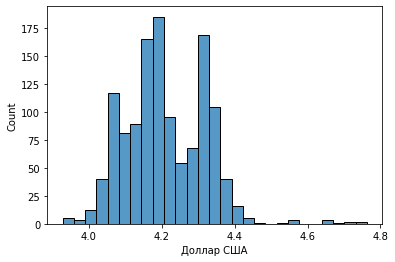

In [6]:
# распределение логарифма курса доллара США - близко к нормальному
sns.histplot(df_train['Доллар США'].apply(lambda w: np.log(w + 1)));

In [7]:
# будем предсказывать курс доллара США наивным способом - по медиане на тренировочной выборке
y_pred_naive = y_train.median() * np.ones_like(y_test)

# получившиеся метрики
MAE_naive = mean_absolute_error(y_test, y_pred_naive)
MSE_naive = mean_squared_error(y_test, y_pred_naive)
MAPE_naive = mean_absolute_percentage_error(y_test, y_pred_naive)

MAE_naive, MSE_naive, MAPE_naive

(5.911159493670885, 69.4573535136709, 0.08610769032228481)

MAE означает «Средняя абсолютная ошибка» и представляет собой показатель, используемый для измерения средней абсолютной разницы между прогнозируемыми значениями и фактическими значениями.

MAPE означает «Средняя абсолютная ошибка в процентах» и представляет собой показатель, используемый для измерения процентной разницы между прогнозируемыми значениями и фактическими значениями.

MSE расшифровывается как «Mean Squared Error» и представляет собой показатель, используемый для измерения среднеквадратичной разницы между прогнозируемыми значениями и фактическими значениями.

In [8]:
# построим предсказательную модель - модель линейной регрессии
model_reg = LinearRegression()
model_reg.fit(X_train[num_features], y_train)
y_pred = model_reg.predict(X_test[num_features])

# посчитаем метрики по новым предсказаниям
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)

MAE, MSE, MAPE

(2.1187526499203413, 6.947712143014699, 0.031924178011880425)

**Вывод:** Видим, что после построения предсказательной модели метрики качества сильно улучшились. Так, MAPE сократилась примерно с 8,6% до 3,2%, что является очень хорошим показателем. Тем не менее попробуем оптимизировать модель с помощью подбора гиперпараметров и функции GridSearchCV.

In [9]:
alphas = np.logspace(-2, 4, 20)

linear_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('linear_model', Ridge()) 
])

searcher = GridSearchCV(
    linear_pipe, [{'linear_model__alpha': alphas}],
    scoring = "neg_root_mean_squared_error", 
    cv = 10, n_jobs = -1
)

searcher.fit(X_train[num_features], y_train)
best_alpha = searcher.best_params_["linear_model__alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 127.4275


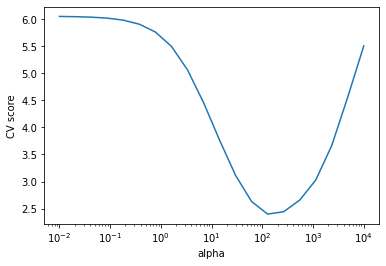

In [10]:
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

In [11]:
y_pred = searcher.predict(X_test[num_features])
y_pred_train = searcher.predict(X_train[num_features])

print('Train MAPE:', mean_absolute_percentage_error(y_train, y_pred_train))
print('Test MAPE:', mean_absolute_percentage_error(y_test, y_pred))

Train MAPE: 0.027717083300573306
Test MAPE: 0.027115758606984546


**Вывод:** Таким образом, после оптимизации модели мы получили ещё более точные результаты - средняя абсолютная ошибка в процентах сократилась примерно до 2,7% на тестовой выборке! Получившуюся предсказательную модель можно использовать для построения оптимальной инвестиционной стратегии в дальнейшем.